### Упражнение 6. Бустинг

>На основе 7-го домашнего задания осени 2019-го года из курса https://github.com/esokolov/ml-course-hse.

#### Подготовка данных

Мы будем использовать данные из [соревнования](https://www.kaggle.com/c/home-credit-default-risk/overview). 
* Загрузите таблицу application_train.csv;
* Запишите в Y столбец с целевой переменной (TARGET);
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.


In [218]:
start_data = pd.read_csv('C:/Users/Евген/Downloads/application_train.csv.zip',compression='zip')

In [221]:
#заполним пропуски в данных
fill_data = start_data.fillna(method='bfill')

In [223]:
#небольшой процент данных незаполнился-удалим
fill_data.dropna(axis=0,inplace=True)

In [224]:
#проверим пропуски
for i in fill_data.columns:
    if fill_data[i].isnull().sum()!=0:
        print(i)
        print(fill_data[i].isnull().sum())
        print()

In [592]:
X = fill_data.drop(['SK_ID_CURR', 'TARGET'], axis=1)
Y = fill_data['TARGET']

In [593]:
#смотрим пропуски целевой переменной
Y.isnull().sum()

0

In [594]:
#16 категориальных признаков
# 104 числовых
X.dtypes.value_counts()

float64    65
int64      39
object     16
dtype: int64

In [595]:
#выделим вещественные признаки
types_column  = pd.DataFrame(X.dtypes,columns = ['types'])
num_feat_X = types_column[types_column['types']!='object']
list_of_num = list(A.index)

In [596]:
#делим выборки на train и test
X_train, X_test, y_train, y_test = train_test_split\
                    (X[list_of_num], Y, test_size=0.3,random_state = 0)

#### Из коробки

Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 
Почему получилась заметная разница в качестве? 

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [597]:
%%time
model_LGB = lgb.LGBMClassifier()
model_LGB.fit(X_train, y_train)
average_precision_score(y_test, model_LGB.predict_proba(X_test)[:,1])

Wall time: 12.8 s


0.22003186723180254

In [598]:
%%time
model_cat = cb.CatBoostClassifier(verbose=0)
model_cat.fit(X_train, y_train)
average_precision_score(y_test, model_cat.predict_proba(X_test)[:,1])

Wall time: 2min 39s


0.21980972541280897

#### Подбор параметров

Подберите оптимальные с точки зрения метрики качества параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения.

Масштаб значений предлагается посмотреть в [семинаре](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/seminars/sem10-gbm.ipynb) про библиотеки.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма. 

LGBM

0.19936008938985295


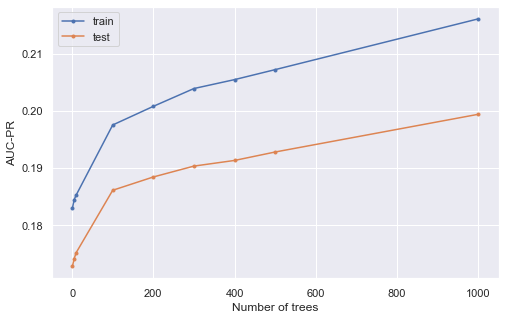

Wall time: 6min 20s


In [599]:
%%time
#сначала зафиксируем learning_rate=0.001
#и подберем n_estimators
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 1000]

value_train = []
value_test = []
for n in n_trees:
    model_LGB = lgb.LGBMClassifier(n_estimators=n,learning_rate=0.001)
    model_LGB.fit(X_train, y_train)
    v_train = average_precision_score(y_train, model_LGB.predict_proba(X_train)[:,1])
    v_test = average_precision_score(y_test, model_LGB.predict_proba(X_test)[:,1])
    value_train.append(v_train)
    value_test.append(v_test)
print(max(value_test))    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, value_train, marker='.', label='train')
plt.plot(n_trees, value_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-PR')
plt.legend()

plt.show()

0.19843262789871302


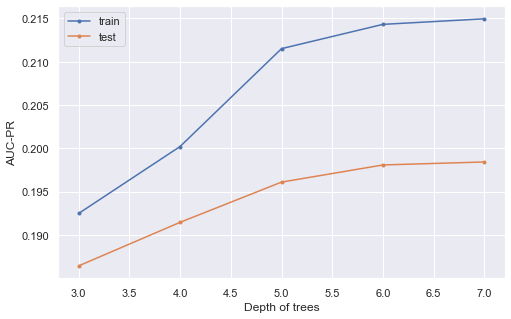

Wall time: 9min 23s


In [600]:
%%time
#далее подберем глубину дерева из отрезка [3,7]
depth = list(range(3, 8, 1))
n_trees = 1000
value_train = []
value_test = []
for d in depth:
    model_LGB = lgb.LGBMClassifier(n_estimators=n_trees, max_depth=d,learning_rate=0.001)
    model_LGB.fit(X_train, y_train)
    v_train = average_precision_score(y_train, model_LGB.predict_proba(X_train)[:,1])
    v_test = average_precision_score(y_test, model_LGB.predict_proba(X_test)[:,1])
    value_train.append(v_train)
    value_test.append(v_test)

print(max(value_test))
plt.figure(figsize=(8, 5))
plt.plot(depth, value_train, marker='.', label='train')
plt.plot(depth, value_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-PR')
plt.legend()

plt.show()

CAT BOOST

0.19075643678832302


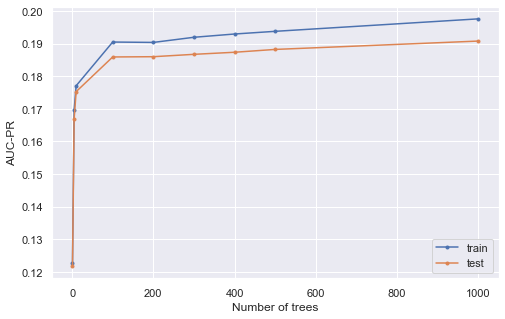

Wall time: 6min 38s


In [601]:
%%time
#сначала зафиксируем learning_rate=0.001
#и подберем n_estimators
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 1000]

value_train = []
value_test = []
for n in n_trees:
    model_cat = cb.CatBoostClassifier(n_estimators=n,learning_rate=0.001,verbose=0)
    model_cat.fit(X_train, y_train)
    v_train = average_precision_score(y_train, model_cat.predict_proba(X_train)[:,1])
    v_test = average_precision_score(y_test, model_cat.predict_proba(X_test)[:,1])
    value_train.append(v_train)
    value_test.append(v_test)

print(max(value_test))    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, value_train, marker='.', label='train')
plt.plot(n_trees, value_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-PR')
plt.legend()

plt.show()

0.19075643678832302


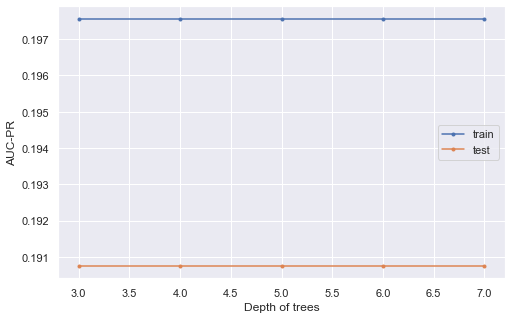

Wall time: 13min 20s


In [602]:
%%time
#далее подберем глубину дерева из отрезка [3,7]
depth = list(range(3, 8, 1))
n_trees = 1000
value_train = []
value_test = []
for d in depth:
    model_cat = cb.CatBoostClassifier(n_estimators=n,learning_rate=0.001,verbose=0)
    model_cat.fit(X_train, y_train)
    v_train = average_precision_score(y_train, model_cat.predict_proba(X_train)[:,1])
    v_test = average_precision_score(y_test, model_cat.predict_proba(X_test)[:,1])
    value_train.append(v_train)
    value_test.append(v_test)

print(max(value_test))
plt.figure(figsize=(8, 5))
plt.plot(depth, value_train, marker='.', label='train')
plt.plot(depth, value_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-PR')
plt.legend()

plt.show()

#### Кодирование категориальных признаков

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов. 

Как меняется время, необходимое для обучения моделей в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков. 

CAT BOOST

In [606]:
X_full = pd.get_dummies(X)

In [607]:
#делим выборки на train и test
X_train, X_test, y_train, y_test = train_test_split\
                    (X_full, Y, test_size=0.3,random_state = 0)

In [608]:
%%time
model_cat = cb.CatBoostClassifier(n_estimators=1000,learning_rate=0.001,verbose=0,max_depth=3)
model_cat.fit(X_train, y_train)
average_precision_score(y_test, model_cat.predict_proba(X_test)[:,1])

Wall time: 2min 3s


0.18914685511666965

Воспользуемся встроенными методами обработки

In [609]:
#выделим категориальные признаки
types_column  = pd.DataFrame(X.dtypes,columns = ['types'])
category_feat_X = types_column[types_column['types']=='object']
list_of_category = list(category_feat_X.index)

In [610]:
X_train, X_test, y_train, y_test = train_test_split\
                    (X, Y, test_size=0.3,random_state = 0)

In [612]:
%%time
model_cat = cb.CatBoostClassifier(n_estimators=1000,learning_rate=0.001,\
                                  verbose=0,max_depth=3,cat_features=list_of_category)
model_cat.fit(X_train, y_train)
average_precision_score(y_test, model_cat.predict_proba(X_test)[:,1])

Wall time: 6min 25s


0.18707648070035734

Время обработки значительно увеличивается(примерно в 3 раза). Результат ниже...

LGBMClassifier

Тут ситуация несколько сложнее, так как pd.get_dummies не выдает кодировку в ASCII...

In [615]:
X_full.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_full.columns]

In [616]:
#делим выборки на train и test
X_train, X_test, y_train, y_test = train_test_split\
                    (X_full, Y, test_size=0.3,random_state = 0)

In [619]:
%%time
model_LGB = lgb.LGBMClassifier(n_estimators=1000, max_depth=7,learning_rate=0.001)
model_LGB.fit(X_train, y_train)
average_precision_score(y_test, model_LGB.predict_proba(X_test)[:,1])

Wall time: 2min 37s


0.20304594144261337

Теперь посмотрим как справляется внутренний механизм кодировки

In [640]:
types_column  = pd.DataFrame(X.dtypes,columns = ['types'])
category_feat_X = types_column[types_column['types']=='object']
list_of_category = list(category_feat_X.index)

In [641]:
for c in list_of_category:
    X[c] = X[c].astype('category')

In [642]:
X_train, X_test, y_train, y_test = train_test_split\
                    (X, Y, test_size=0.3,random_state = 0)

In [643]:
%%time
model_LGB = lgb.LGBMClassifier(n_estimators=1000, max_depth=7,\
                               learning_rate=0.001,\
                               categorical_feature=list_of_category,n_jobs=-1)
model_LGB.fit(X_train, y_train)
average_precision_score(y_test, model_LGB.predict_proba(X_test)[:,1])

Wall time: 2min 22s


0.20315669492201702

#### Стекинг

Реализуйте Стекинг подобранных в предыдущем задании моделей и сравните качество. Обратите внимание на данные, на которых обучаются 

In [653]:
for c in list_of_category:
    X[c] = X[c].astype('category')

In [662]:
X_train, X_test, y_train, y_test = train_test_split\
                    (X, Y, test_size=0.3,random_state = 0)

In [663]:
training, valid, y_training, y_valid = train_test_split\
                    (X_train, y_train, test_size=0.5,random_state = 0)

In [664]:
%%time
model_LGB = lgb.LGBMClassifier(n_estimators=1000, max_depth=7,\
                               learning_rate=0.001,\
                               categorical_feature=list_of_category,n_jobs=-1)
model_LGB.fit(training, y_training)

model_cat = cb.CatBoostClassifier(n_estimators=1000,learning_rate=0.001,\
                                  verbose=0,max_depth=3,cat_features=list_of_category)
model_cat.fit(training, y_training)

Wall time: 5min 51s


In [665]:
from sklearn.linear_model import LogisticRegression

pred_1 = model_LGB.predict(valid)
pred_2 = model_cat.predict(valid)
test_1 = model_LGB.predict(X_test)
test_2 =  model_cat.predict(X_test)
stack_1 = np.column_stack((pred_1,pred_2))
stack_2 = np.column_stack((test_1,test_2))
meta_model = LogisticRegression()


In [667]:
meta_model.fit(stack_1,y_valid)
final_model = meta_model.predict(stack_2)

In [671]:
average_precision_score(y_test, meta_model.predict_proba(stack_2)[:,1])

0.08029268292682927

#### Важность признаков

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог, с которого начинается "хвост" менее важных признаков) и обучите модель с теми же параметрами на получившихся данных. Сильно ли упало качество при удалении признаков?

In [ ]:
X_train, X_test, y_train, y_test = train_test_split\
                    (X, Y, test_size=0.3,random_state = 0)

In [681]:
model_LGB = lgb.LGBMClassifier(n_estimators=1000, max_depth=7,\
                               learning_rate=0.001,\
                               categorical_feature=list_of_category,n_jobs=-1)
model_LGB.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt',
               categorical_feature=['NAME_CONTRACT_TYPE', 'CODE_GENDER',
                                    'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                                    'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
                                    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                                    'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
                                    'WEEKDAY_APPR_PROCESS_START',
                                    'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
                                    'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE',
                                    'EMERGENCYSTATE_MODE'],
               class_weight=None, colsample_bytree=1.0, importance_type='split',
               learning_rate=0.001, max_depth=7, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,


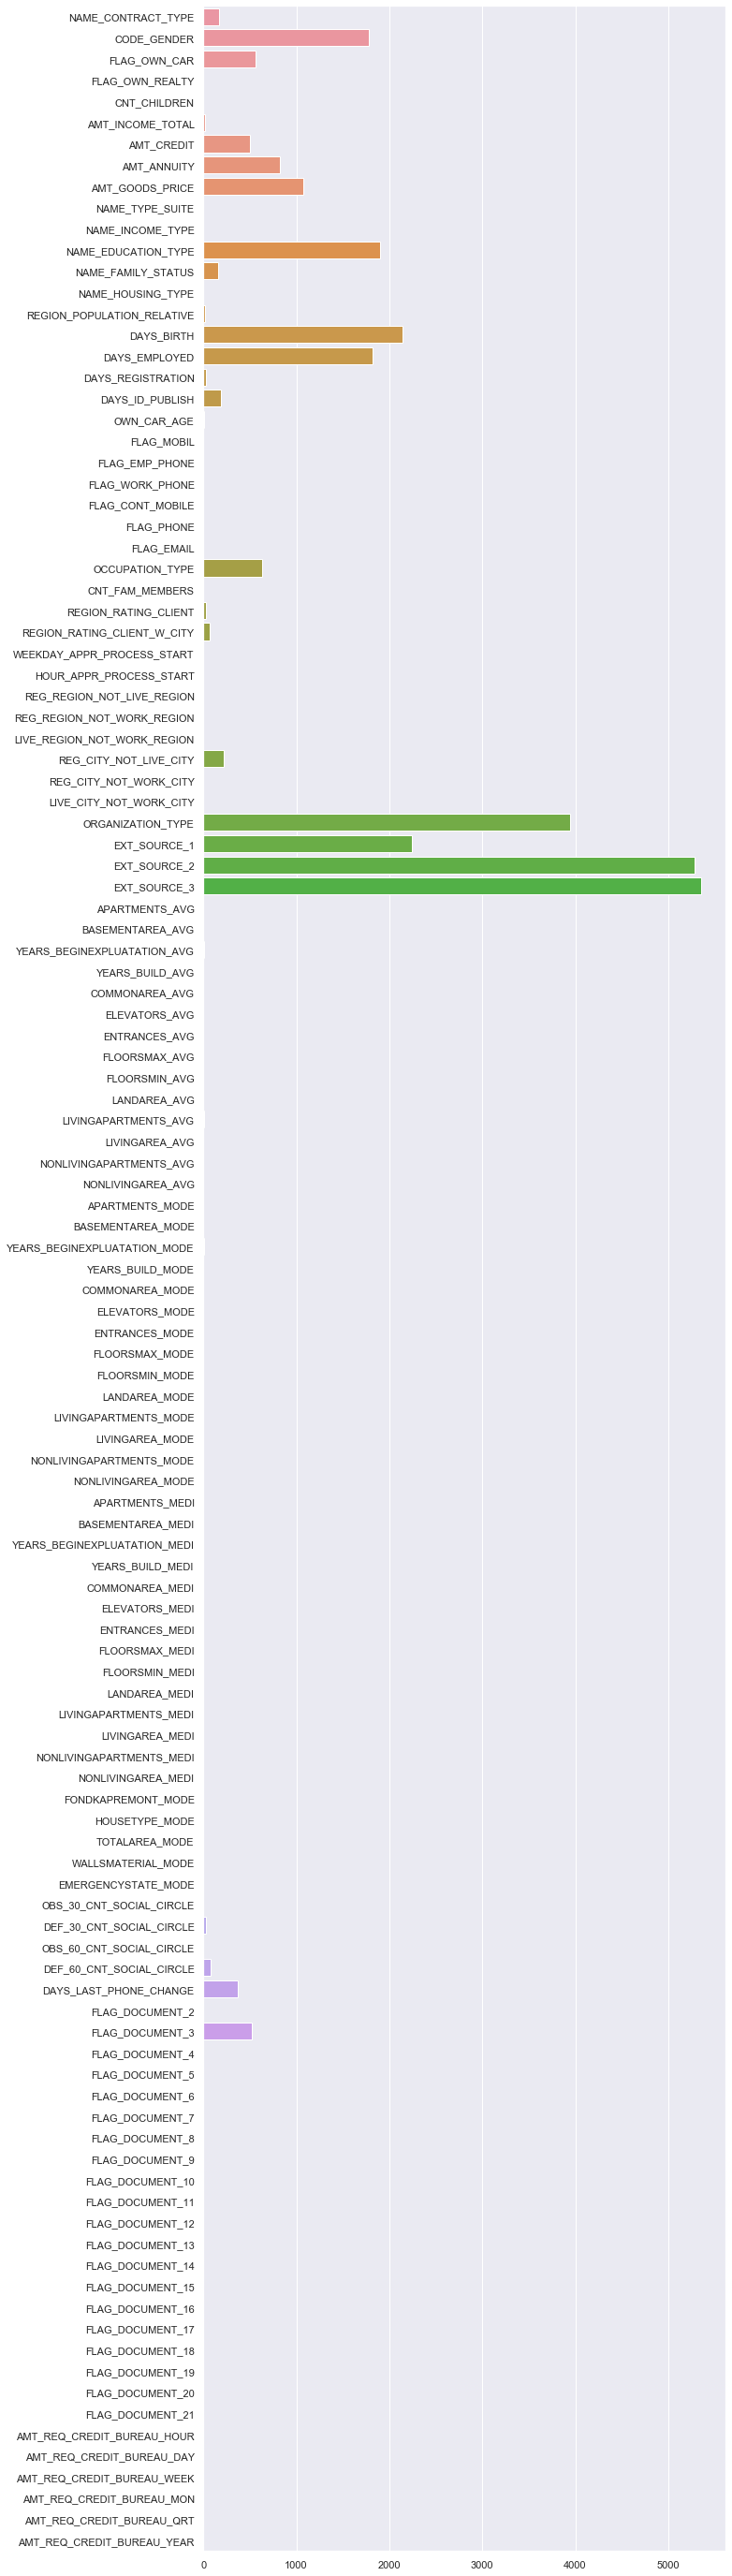

In [689]:
importances = model_LGB.feature_importances_
plt.figure(figsize=(10, 50))

sns.barplot(y=X.columns, x=importances, orient='h');

In [704]:
importances = model_LGB.feature_importances_

feat_names = X.columns
#зипуем названия признаков и значимость
result_importances = dict(zip(feat_names, importances))
#сортируем по убыванию
list_sorted_feat  = sorted(result_importances.items(), key=lambda x: x[1],reverse=True)


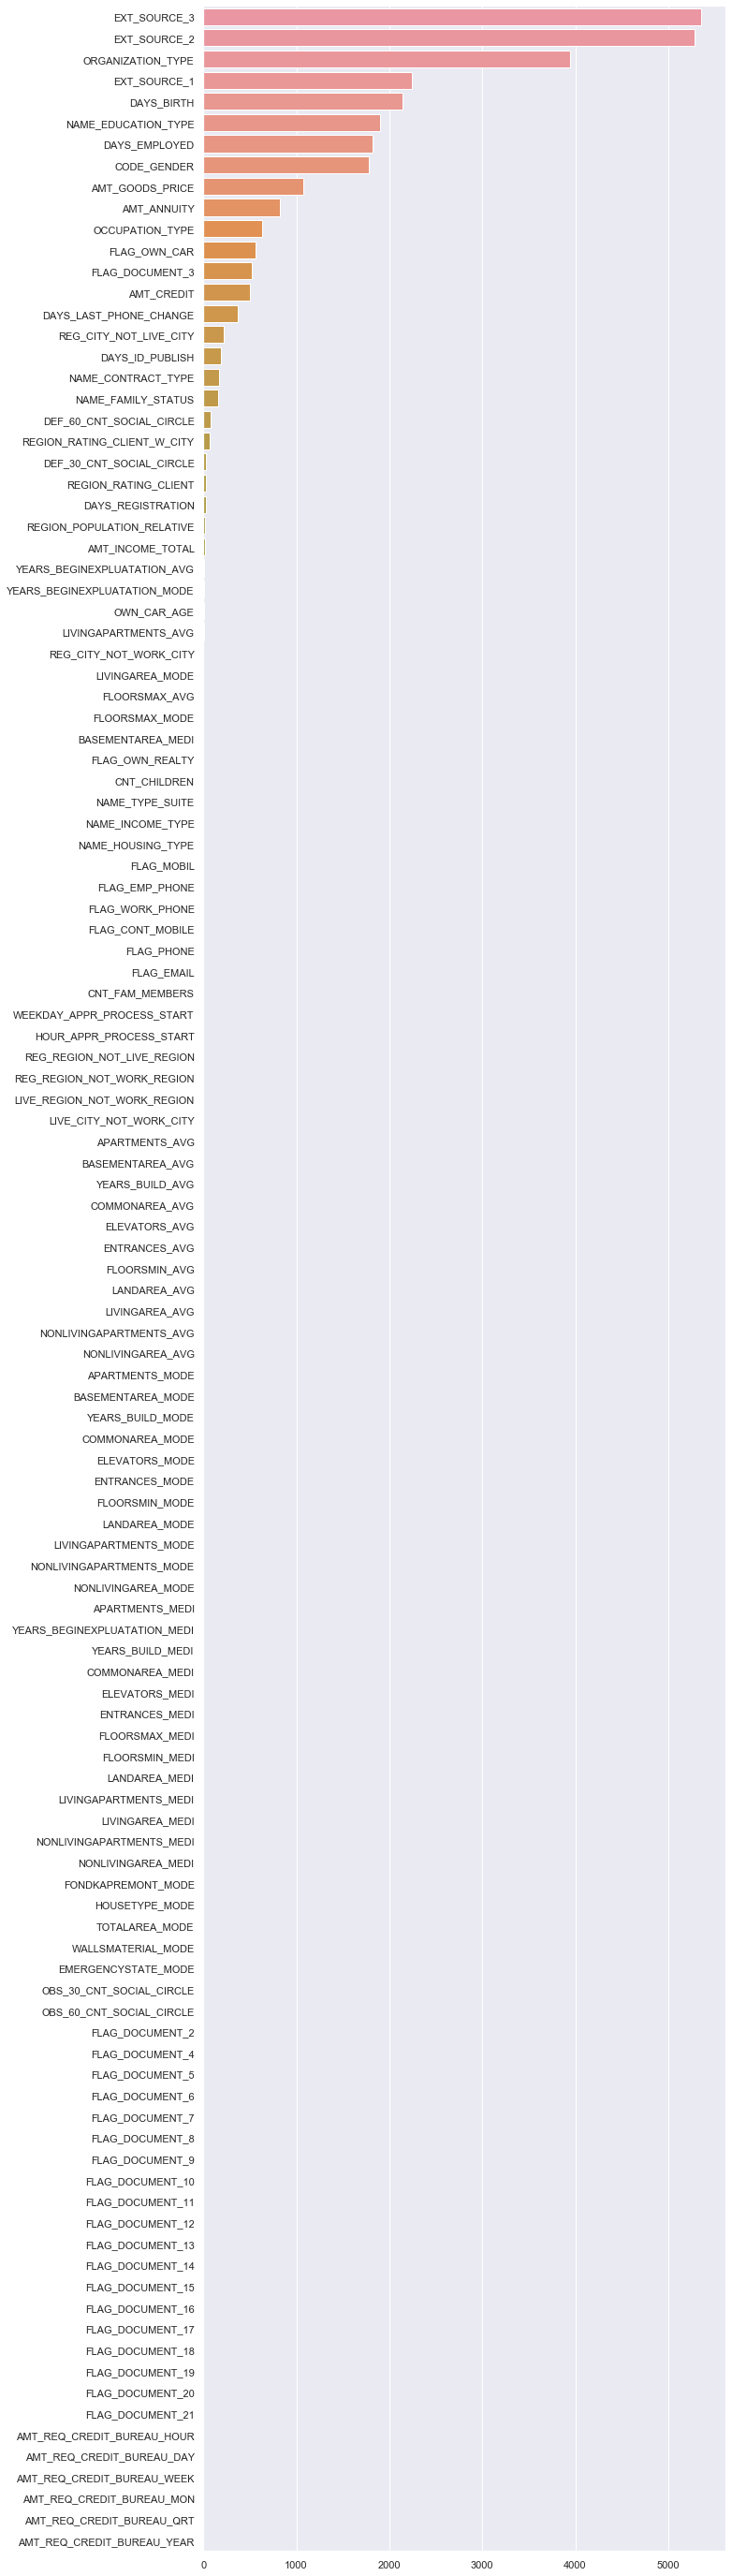

In [712]:
name_imp_feat = []
count_imp_feat = []
for i in range(len(list_sorted_feat)):
    name_imp_feat.append(list_sorted_feat[i][0])
    count_imp_feat.append(list_sorted_feat[i][1])
plt.figure(figsize=(10, 50))
sns.barplot(y=name_imp_feat, x=count_imp_feat, orient='h');

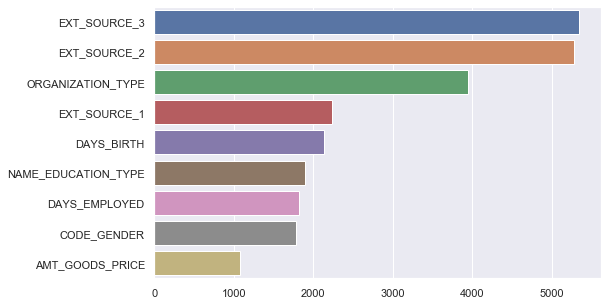

In [715]:
#отберем признаки со значимостью более 1000
name_imp_feat = []
count_imp_feat = []
for i in range(len(list_sorted_feat)):
    if list_sorted_feat[i][1] > 1000:
        name_imp_feat.append(list_sorted_feat[i][0])
        count_imp_feat.append(list_sorted_feat[i][1])
plt.figure(figsize=(8, 5))
sns.barplot(y=name_imp_feat, x=count_imp_feat, orient='h');

In [717]:
X_train, X_test, y_train, y_test = train_test_split\
                    (X[name_imp_feat], Y, test_size=0.3,random_state = 0)

In [720]:
model_LGB = lgb.LGBMClassifier(n_estimators=1000, max_depth=7,\
                               learning_rate=0.001,\
                               categorical_feature=list_of_category,n_jobs=-1)
model_LGB.fit(X_train, y_train)
average_precision_score(y_test, model_LGB.predict_proba(X_test)[:,1])

0.2000853043589219

In [726]:
types_column  = pd.DataFrame(X[name_imp_feat].dtypes,columns = ['types'])
category_feat_X = types_column[types_column['types']=='category']
list_of_category = list(category_feat_X.index)

In [728]:
model_cat = cb.CatBoostClassifier(n_estimators=1000,learning_rate=0.001,\
                                  verbose=0,max_depth=3,cat_features=list_of_category)
model_cat.fit(X_train, y_train)
average_precision_score(y_test, model_cat.predict_proba(X_test)[:,1])

0.1924025730066453